# Tree sway video analysis for an oak tree in Trout Lake, Wisconsin

**Author: Joe Ammatelli, jamma@uw.edu, University of Washington, 2023**

**Overview**

This notebook facilitates the extraction and validation of tree sway frequency data from a video.
The notebook was specifically implemmented for evaluating video and accelerometer data for an oak tree in Trout Lake, Wisconsin. 

Here, we extract sway frequency data from a video using two adapted video processing algorithms, the Virtual Vision Sensor algorithm from Schumacher and Shariati (2013) and the Multilevel Binary Thresholding algorithm from Ferrer et al. (2013), and compare the results to sway frequencies extracted from 2 lengths of accelerometer data for the same tree.

The notebook is divided into 5 parts:
1. Initialize processing parameters
2. Extract sway frequencies using the 'Virtual Vision Sensor' (VVS) algorithm
3. Extract sway frequencies using the Multilevel Binary Thresholding (MBT) algorithm
4. Extract sway frequencies from accelerometer data
5. Plot video and accelerometer data together (for publication quality plot)

The workflow has been designed so that users configure essential processing parameters in step 1 and then simply step through the remaining cells.

Part 5 includes code used to generate a publication quality figure for one of the data samples (Trout-D).

**Description of Video Processing Pipeline**

The logic for both video processing algorithms has been abstracted into a modular workflow with 4 abstract steps:
1. Translating a video to vibration signals (vid2vib_utils.py)
2. Estimating the power spectral density (PSD) of each vibration signal (spectra_utils.py)
3. Aggregating frequency content across all vibration signals (aggregate_utils.py)
4. Reporting the output peak frequency (plotting_utils.py)

Functions related to each abstract step are implemented in the util python files in parentheses above.

Each video processing algorithm then has an Analyzer object that combines functions from the util files to create an end-to-end algorithm. Each Analyzer object has one function corresponding to each abstract step. These functions serve as wrappers and enable users users to customize key elements of the video processing pipeline without modifying the pipeline itself. For key computation steps, users can invoke existing functions or define their own. For example, for step 2, users can choose from existing methods for estimating the power spectral density (see spectra_utils.py) or define their own.

Once processing parameters have been configured, the user can simiply call each step of the analyer object to process the video.

**Sources**

Ferrer, B., Espinosa, J., Roig, A. B., Perez, J., & Mas, D. (2013). Vibration frequency 
    measurement using a local multithreshold technique. Optics Express, 21(22), 26198–26208. 
    https://doi.org/10.1364/OE.21.026198

Schumacher, T., & Shariati, A. (2013). Monitoring of Structures and Mechanical Systems Using 
    Virtual Visual Sensors for Video Analysis: Fundamental Concept and Proof of Feasibility. 
    Sensors, 13(12), Article 12. https://doi.org/10.3390/s131216551

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import datetime
import scipy

import VVSAnalyzer
import MBTAnalyzer
import vid2vib_utils
import spectra_utils
import aggregate_utils
import plotting_utils
import accelerometer_utils

## 1. Initialize processing parameters

### 1.1 Choose video and accelerometer data

In [2]:
# Video samples and corresondting time-stamp
vid_datetimes = {'trout-a' : '2019-8-15 17:07:18', 
                 'trout-b' : '2019-8-15 17:30:01', 
                 'trout-c' : '2019-8-15 17:32:34', 
                 'trout-d' : '2019-8-15 18:00:01', 
                 'trout-e' : '2019-8-15 18:09:06'}

# name of video sample to process
vid_name = 'trout-d'

# path to video sample
vid_path = f'../../../../Desktop/TroutLake/{vid_name}.MP4'

# path to accelerometer data
acc_path = '../../../../Desktop/TroutLake/Trout_accelerometer.csv'

#### 1.1.1 Verift the video datetime

In [3]:
vid2vib_utils.get_video_datetime(vid_path)

datetime.datetime(2019, 8, 15, 18, 0, 1)

### 1.2 Choose a region of interest (ROI) or optionally define your own

In [4]:
# regions of interest
rois = {'tree' : [100, 900, 750, 1180],
        'trunk_branch' : [275, 870, 760, 1025],
        'branch' : [275, 725, 760, 875], 
        'trunk' : [835, 865, 980, 1010]}

# choose region of interest
roi = 'trunk'

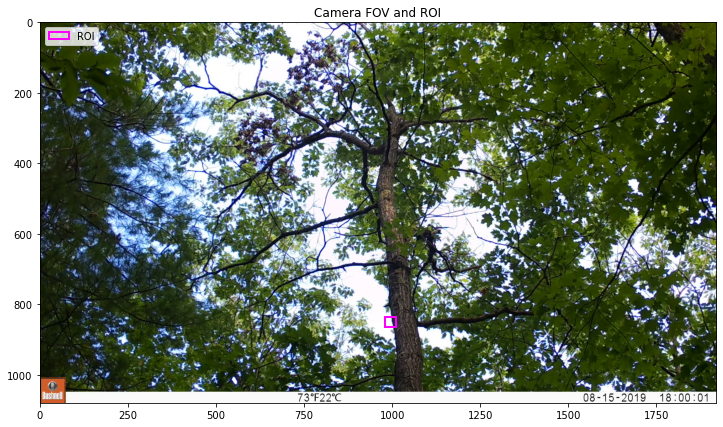

In [5]:
ax = plotting_utils.plot_frame(vid_path, title='Camera FOV and ROI', figsize=(14,7))
plotting_utils.plot_rois(ax, [rois[roi]])
ax.legend(['ROI'], loc='upper left')

### 1.3 Specify a location to store the processing context, output data, and figures

In [6]:
out_prefix = f'./output/{vid_name}_{roi}'

### 1.4 Define video processing parameters

The video processing pipeline, regardless of algorithm type, is divided into 4 main steps:
1. Translating a video to vibration signals
2. Estimating the power spectral density (PSD) of each vibration signal
3. Aggregating frequency content across all vibration signals
4. Reporting the output peak frequency

The parameters for each step are configured below. For a description of functions their arguments see:
* vid2vib_utils.py
* spectra_utils.py
* aggregate_utils.py
* plotting_utils.py
* accelerometer_utils.py

#### 1.4.1 Parameters for video to vibration translation

In [7]:
# keyword arguments for VVS video to vibration translation (which uses vid2vib.uncompressed_vid)
vid2vib_vvs_kwargs = {'reduction':'gray'}

# keyword argumetns for MBT video to vibration translation (which uses vid2vib.mbt)
vid2vib_mbt_kwargs = {'reduction':'gray'}

# number of MBT signals to generate
nlevels = 8

#### 1.4.2 Parameters for estimating the power spectral density (PSD) of each signal

In [8]:
# lower bound of canidate frequencies
freqmin = 0.15

# upper bound of candidate frequencies
freqmax = 0.5

# function used to estimate PSD of vibration signals
spectra_func = spectra_utils.get_spectra_periodogram

# kwargs for spectra_func
spectra_func_kwargs = {'window':'hann', 
                       'nfft':None}

#### 1.4.3  Parameters for aggregating the frequency content across all vibration spectra

In [9]:
# function used to aggregate vibration PSDs
dom_freq_func = spectra_utils.get_dom_freq_peak_finder

# kwargs for aggregating function
dom_freq_func_kwargs = {}

# masks applied to vibration signals
percentile=75  # percentile of peak prominences below which signals are masked

# mask type
masks = [{'name':f'Prominence, {percentile}th percentile',
          'weight':'prominence',
          'kwargs':{'stat_reduc':'percentile', 'percentile':percentile}}, 
        ]

#### 1.4.4 Parameters for reporting the output

In [10]:
figsize=(14,7)

#### 1.5 Define accelerometer processing parameters

In [11]:
# accelerometer sampling frequency in Hz
acc_fs = 16 

# processing parameters for short accelerometer segment
short_segment_length = 1 # minutes
acc_short_spectra_func_kwargs = spectra_func_kwargs


# processing parameters for long segment
long_segment_length = 30 # minutes
# kwargs defined below since depend on video output

## 2. Extract sway frequencies using the 'Virtual Vision Sensor' (VVS) algorithm

### 2.1 Create a VVSAnalyer object

The VVSAnalyzer object provides a convenient and compact way to execute each step of the processing pipeline.

In [12]:
vvs = VVSAnalyzer.VVSAnalyzer(vid_path, rois[roi], out_prefix)

### 2.2 Translate the video data into vibration signals using the VVS translation

In [13]:
vib_vvs, fps = vvs.vid2vib(vid2vib_vvs_kwargs)

Reading video into array
1805
Finished reading video into array


In [14]:
fps

30.00747694608291

#### 2.2.1 Verify fps is as expected

In [15]:
fps

30.00747694608291

### 2.3 Estimate the power spectral density (PSD) for each vibration signal 

In [16]:
freq_vvs, pxx_vvs = vvs.compute_spectra(freqmin, freqmax, spectra_func, spectra_func_kwargs)

Computing pixel spectra
Finished computing spectra


### 2.4 Aggregate the frequency content across all vibration spectra

In [17]:
agg_df_vvs, pxx_avg_vvs, pxx_avg_peak_idx_vvs, dom_freq, masked, masked_avg_spectrums, masked_avg_spectrums_peak_idxs = vvs.aggregate(dom_freq_func, dom_freq_func_kwargs, masks)
pixel_counts, bins = aggregate_utils.hist_spectrum(masked[0], freq_vvs)
hist_peak_idx, _, _ = spectra_utils.find_dominant_peak(pixel_counts, criteria='magnitude')

### 2.5 Plot Output

,unmasked_avg_spectrum_peak,unmasked_mode,mask0_avg_spectrum_peak,mask0_mode
0,0.238096,0.498171,0.238096,0.238096


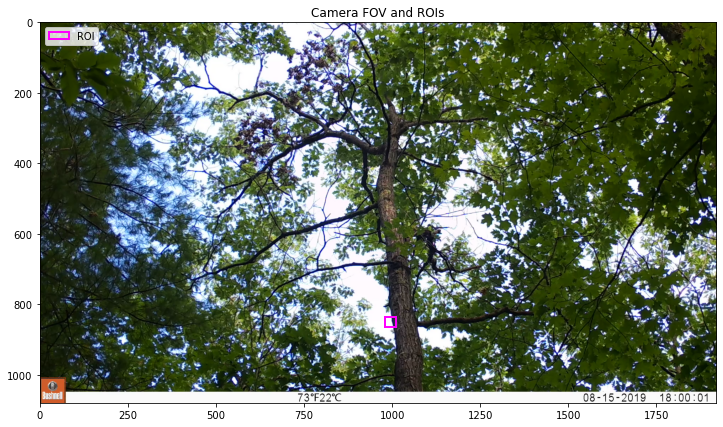

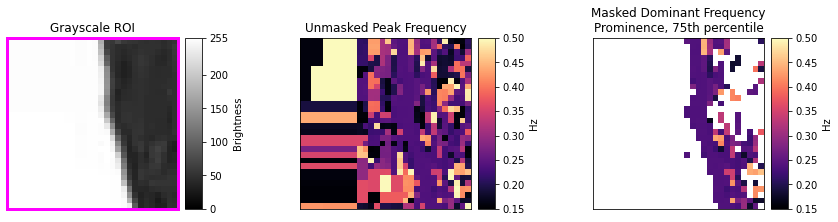

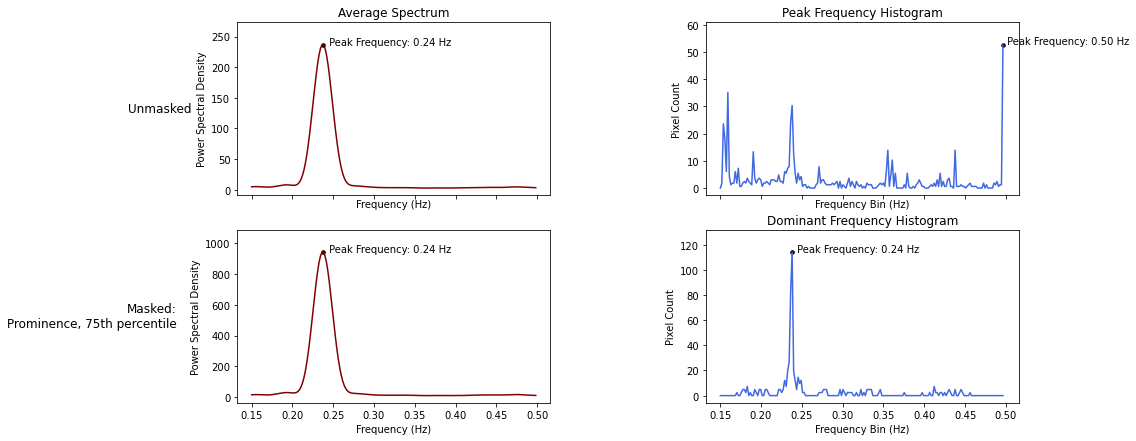

In [18]:
vvs.report(figsize=figsize)

## 3. Extract sway frequencies using the Multilevel Binary Thresholding (MBT) algorithm

### 3.1 Create a MBTAnalyer object

The MBTAnalyzer object provides a convenient and compact way to execute each step of the processing pipeline.

In [19]:
mbt = MBTAnalyzer.MBTAnalyzer(vid_path, rois[roi], nlevels, out_prefix)

### 3.2 Translate the video data into vibration signals using the MBT translation

In [20]:
vib_mbt, _, levels = mbt.vid2vib(vid2vib_mbt_kwargs)

Generating vibration time series using multilevel binary thresholding
Reading roi into array
Reading video into array
1805
Finished reading video into array
Done reading roi into array
Counting pixels below each threshold
1805
Finished generating signals


### 3.3 Estimate the power spectral density (PSD) for each vibration signal 

In [21]:
freq_mbt, pxx_mbt = mbt.compute_spectra(freqmin, freqmax, spectra_func, spectra_func_kwargs)

Computing pixel spectra
Finished computing spectra


### 3.4 Aggregate the frequency content across all vibration spectra

In [22]:
agg_df_mbt, pxx_avg_mbt, pxx_avg_peak_idx_mbt = mbt.aggregate(dom_freq_func, dom_freq_func_kwargs, masks)

### 3.5 Plot Output

,avg_spectrum_peak
0,0.238096


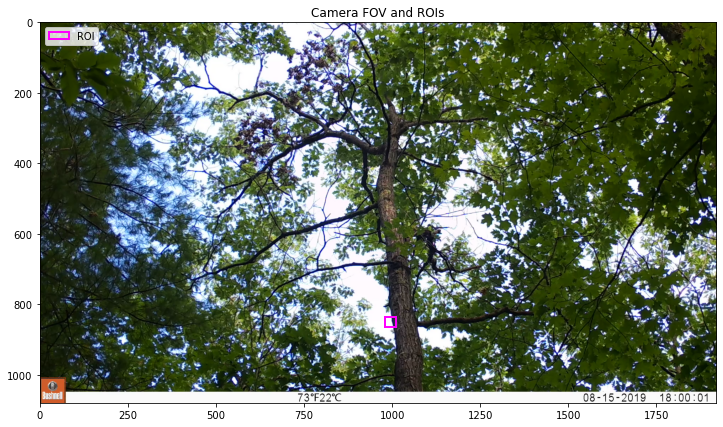

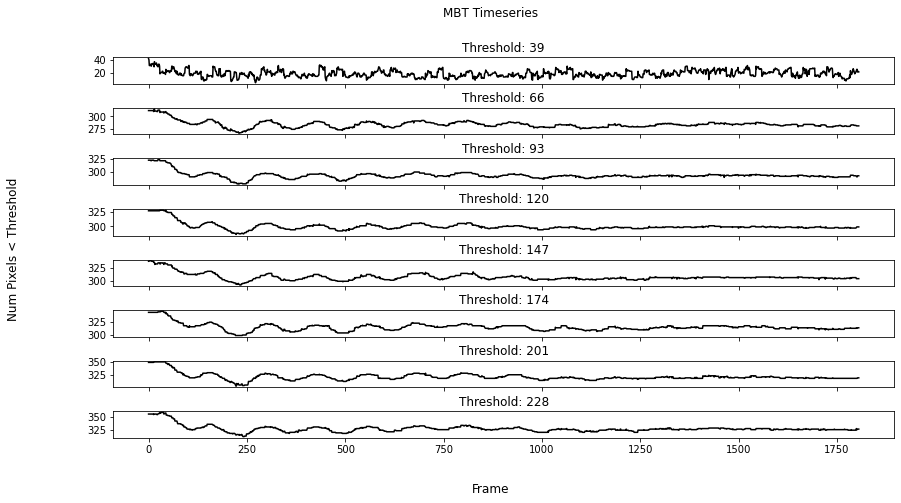

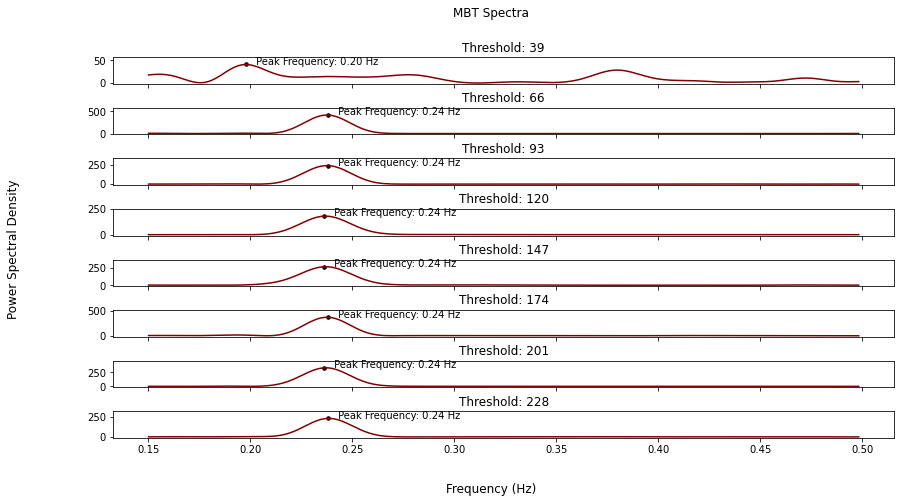

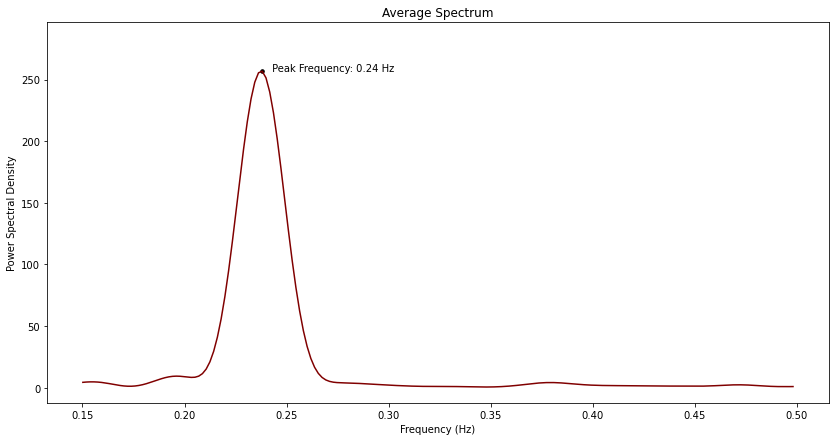

In [23]:
mbt.report(figsize=figsize)

## 4. Extract sway frequencies from accelerometer data

### 4.1 Load the accelerometer data

In [24]:
acc_df = pd.read_csv(acc_path, 
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format=True)

### 4.2 Extract sway frequency from an accelerometer segment with the same start time, duration, and processing parameters as the video

In [25]:
df_acc_short, freq_acc_short, pxx_acc_short, pxx_avg_acc_short, pxx_avg_peak_idx_acc_short = accelerometer_utils.get_accel_spectra(acc_df, 
                                                                                                                                   fs=acc_fs,
                                                                                                                                   t0=vid_datetimes[vid_name],
                                                                                                                                   date_format='%Y-%m-%d %H:%M:%S',
                                                                                                                                   freqmin=freqmin, 
                                                                                                                                   freqmax=freqmax, 
                                                                                                                                   length=short_segment_length,
                                                                                                                                   center=False,
                                                                                                                                   spectra_func=spectra_utils.get_spectra_periodogram,
                                                                                                                                   spectra_func_kwargs=spectra_func_kwargs)

Computing pixel spectra
Finished computing spectra


### 4.3 Extract sway frequency from a 30-minute accelerometer segment using Welch's method

In [26]:
acc_30_spectra_func_kwargs = {'window':'hann', 
                              'nperseg':4800, 
                              'nfft': 8 * spectra_utils.get_next_pow2(vib_vvs.shape[0])}

df_acc30, freq_acc30, pxx_acc30, pxx_avg_acc30, pxx_avg_peak_idx_acc30 = accelerometer_utils.get_accel_spectra(acc_df, 
                                                                                                               fs=acc_fs,
                                                                                                               t0=vid_datetimes[vid_name],
                                                                                                               date_format='%Y-%m-%d %H:%M:%S',
                                                                                                               freqmin=freqmin, 
                                                                                                               freqmax=freqmax, 
                                                                                                               length=long_segment_length,
                                                                                                               spectra_func=spectra_utils.get_spectra_welch,
                                                                                                               spectra_func_kwargs=acc_30_spectra_func_kwargs,
                                                                                                               center=True)

Computing pixel spectra
Finished computing spectra


## 5. Plot video and accelerometer data together (for publication quality plot)

**Note: The following plot has been designed specifically for the trout-d sample. Minor adjustments will likely be needed for other video samples. In particular, all annotations and the signal label parameters (offset parameters) will need to be adjusted.**

### 5.1 Define output signals

#### 5.1.1 Compute possible frequency resolutions

In [27]:
vid_len = vib_vvs.shape[0]  # frames
freq_vid = scipy.fft.rfftfreq(vid_len, 1 / fps)
df_vid = freq_vid[1] - freq_vid[0]

acc_short_len = len(df_acc_short['acc']) # samples
freq_short = scipy.fft.rfftfreq(acc_short_len, 1 / acc_fs)
df_short = freq_short[1] - freq_short[0]

acc_long_len = len(df_acc30['acc']) # samples
freq_30 = scipy.fft.rfftfreq(acc_long_len, 1 / acc_fs)
df_30 = freq_30[1] - freq_30[0]

#### 5.1.2 Define signals and plotting parameters

In [28]:
acc_30 = {'freq' : freq_acc30,
          'frequency_resolution' : df_30,
          'psd' : pxx_avg_acc30, 
          'peak_idx' : pxx_avg_peak_idx_acc30, 
          'label' : 'Accelerometer, 30-min segment', 
          'color' : '#88CCEE', 
          'label_color' : '#88CCEE'}

acc_short = {'freq' : freq_acc_short,
             'frequency_resolution' : df_short,
             'psd' : pxx_avg_acc_short, 
             'peak_idx' : pxx_avg_peak_idx_acc_short, 
             'label' : 'Accelerometer, 60-sec segment', 
             'color' : '#117733', 
             'label_color' : '#117733'}

mbt_output = {'freq' : freq_mbt,
              'frequency_resolution' : df_vid,
              'psd' : pxx_avg_mbt, 
              'peak_idx' : pxx_avg_peak_idx_mbt, 
              'label' : 'MBT, average spectrum', 
              'color' : '#882255', 
              'label_color' : '#882255'}

vvs_hist = {'freq' : bins, 
            'frequency_resolution' : df_vid,
            'psd' : pixel_counts, 
            'peak_idx' : hist_peak_idx, 
            'label' : 'VVS, peak frequency count', 
            'color' : '#AA4499', 
            'label_color' : '#AA4499'}

vvs_avg = {'freq' : freq_vvs,
           'frequency_resolution' : df_vid,
           'psd' : masked_avg_spectrums[0], 
           'peak_idx' : pxx_avg_peak_idx_vvs, 
           'label' : 'VVS, average spectrum', 
           'color' : '#CC6677', 
           'label_color' : '#CC6677'}

#### 5.1.3 Choose output signals to plot

In [29]:
output_signals = [acc_30, acc_short, mbt_output, vvs_hist, vvs_avg]

In [30]:
for i, s in enumerate(output_signals):
    label = s['label']
    peak = s['freq'][s['peak_idx']]
    print(f'{label} : {peak}')

Accelerometer, 30-min segment : 0.240234375
Accelerometer, 60-sec segment : 0.30859375
MBT, average spectrum : 0.23809643572941763
VVS, peak frequency count : 0.23809643572941763
VVS, average spectrum : 0.23809643572941763


### 5.2 Plot

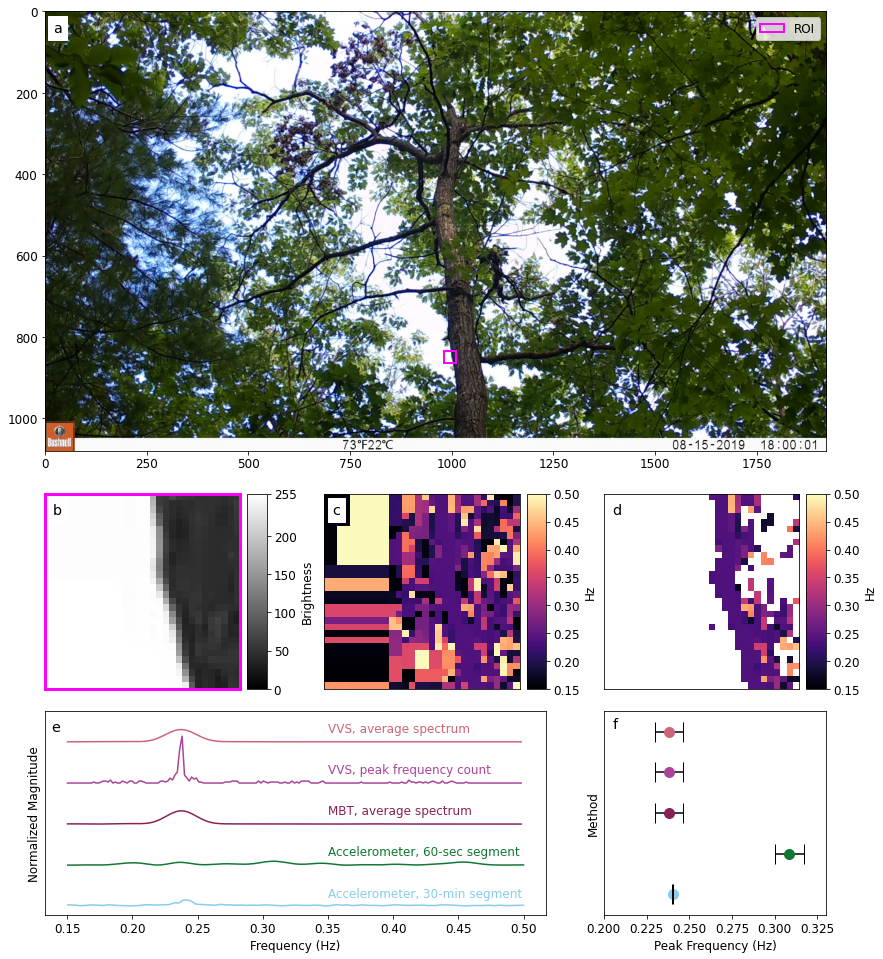

In [31]:
matplotlib.rcParams.update({'font.size': 12})

# define subplot pattern
pattern = '''
AAAAAA
AAAAAA
AAAAAA
AAAAAA
AAAAAA
AAAAAA
AAAAAA
AAAAAA
AAAAAA
BBCCDD
BBCCDD
BBCCDD
BBCCDD
EEEEFF
EEEEFF
EEEEFF
EEEEFF
'''

# create figure with specified pattern
fig, ax = plt.subplot_mosaic(pattern, figsize=(14,17))#, dpi=500)

# Plot frame and ROI
plotting_utils.plot_frame(vid_path, ax=ax['A'])
plotting_utils.plot_rois(ax['A'], [rois[roi]])
ax['A'].annotate('a', (20,50), c='k', backgroundcolor='w', fontsize='large')
ax['A'].legend(['ROI'])

# Plot grayscale ROI
plotting_utils.plot_grayscale_image(vib_vvs[0], 
                                    colorbar=True, 
                                    colorbarlabel='Brightness', 
                                    edgecolor='fuchsia', ax=ax['B'])
ax['B'].annotate('b', (0.75,2.6), c='k', backgroundcolor='w', fontsize='large')

# Plot unmasked freq heat map
plotting_utils.plot_image(dom_freq, 
                          freqmin, 
                          freqmax, 
                          ax=ax['C'], 
                          title=None, 
                          colorbar=True, 
                          colorbarlabel='Hz')
ax['C'].annotate('c', (0.75,2.6), c='k', backgroundcolor='w', fontsize='large')

# Plot masked freq heat map
plotting_utils.plot_image(masked[0], 
                          freqmin, 
                          freqmax, 
                          ax=ax['D'], 
                          title=None, 
                          colorbar=True, 
                          colorbarlabel='Hz')
ax['D'].annotate('d', (0.75,2.6), c='k', backgroundcolor='w', fontsize='large')

# Plot offset spectra
bottom = 0 # where first signal starts
pad = 100 # space between each signal
label_hoffset = 0.35 # horizontal offset of signal label
label_voffset = 23 # vertical  offset of signal label

for s in output_signals:
    f = s['freq']
    df = f[1] - f[0]
    
    psd_normalized = spectra_utils.normalize(s['psd'], dx=df)
    
    ax['E'].plot(f, psd_normalized + bottom,label=s['label'], c=s['color'])
    ax['E'].annotate(s['label'], 
                     (label_hoffset,bottom + label_voffset), 
                     c=s['label_color'], 
                     backgroundcolor='None', 
                     fontsize='medium')
    bottom = bottom + pad

ylim = ax['E'].get_ylim()
ax['E'].set_ylim(ylim[0], 1.05*ylim[1])    

ax['E'].set_ylabel('Normalized Magnitude')
ax['E'].set_xlabel('Frequency (Hz)')

ax['E'].set_yticks([])

ax['E'].annotate('e', (0.1375,425), c='k', backgroundcolor='w', fontsize='large')

# Plot corresponding peaks
for i, s in enumerate(output_signals):
    peak = s['freq'][s['peak_idx']]
    ax['F'].errorbar(peak, i, xerr=s['frequency_resolution'] / 2, color='k', capsize=10)
    ax['F'].scatter(peak, i, color=s['color'], marker='.', s=400, zorder=2)
ax['F'].set_xlim(0.2, 0.33)
ax['F'].set_yticks([])
ax['F'].set_xlabel('Peak Frequency (Hz)')
ax['F'].set_ylabel('Method')
ax['F'].set_ylim(-0.5, 4.5)
ax['F'].annotate('f', (0.205,4.1), c='k', backgroundcolor='w', fontsize='large')

fig.subplots_adjust(hspace=0.5, wspace=0.7)